In [51]:
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
import random
from datetime import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [52]:
# Reading the data 

df = pd.read_csv("./data/AAPL.csv")

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1257 non-null   object 
 1   date         1257 non-null   object 
 2   close        1257 non-null   float64
 3   high         1257 non-null   float64
 4   low          1257 non-null   float64
 5   open         1257 non-null   float64
 6   volume       1257 non-null   int64  
 7   adjClose     1257 non-null   float64
 8   adjHigh      1257 non-null   float64
 9   adjLow       1257 non-null   float64
 10  adjOpen      1257 non-null   float64
 11  adjVolume    1257 non-null   int64  
 12  divCash      1257 non-null   float64
 13  splitFactor  1257 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.6+ KB


In [54]:
df['close'].isnull().any()

False

In [55]:
# Converting object datatype into datetime datatype

df2 = pd.DataFrame(np.log(df['close']))
df2['date'] = pd.to_datetime(df['date']).dt.date

In [56]:
df2

,close,date
0,4.664665,2016-03-23
1,4.660321,2016-03-24
2,4.655768,2016-03-28
3,4.679164,2016-03-29
4,4.696472,2016-03-30
...,...,...
1252,4.820201,2021-03-15
1253,4.832863,2021-03-16
1254,4.826392,2021-03-17
1255,4.791899,2021-03-18


In [57]:
df2.set_index('date', inplace=True)

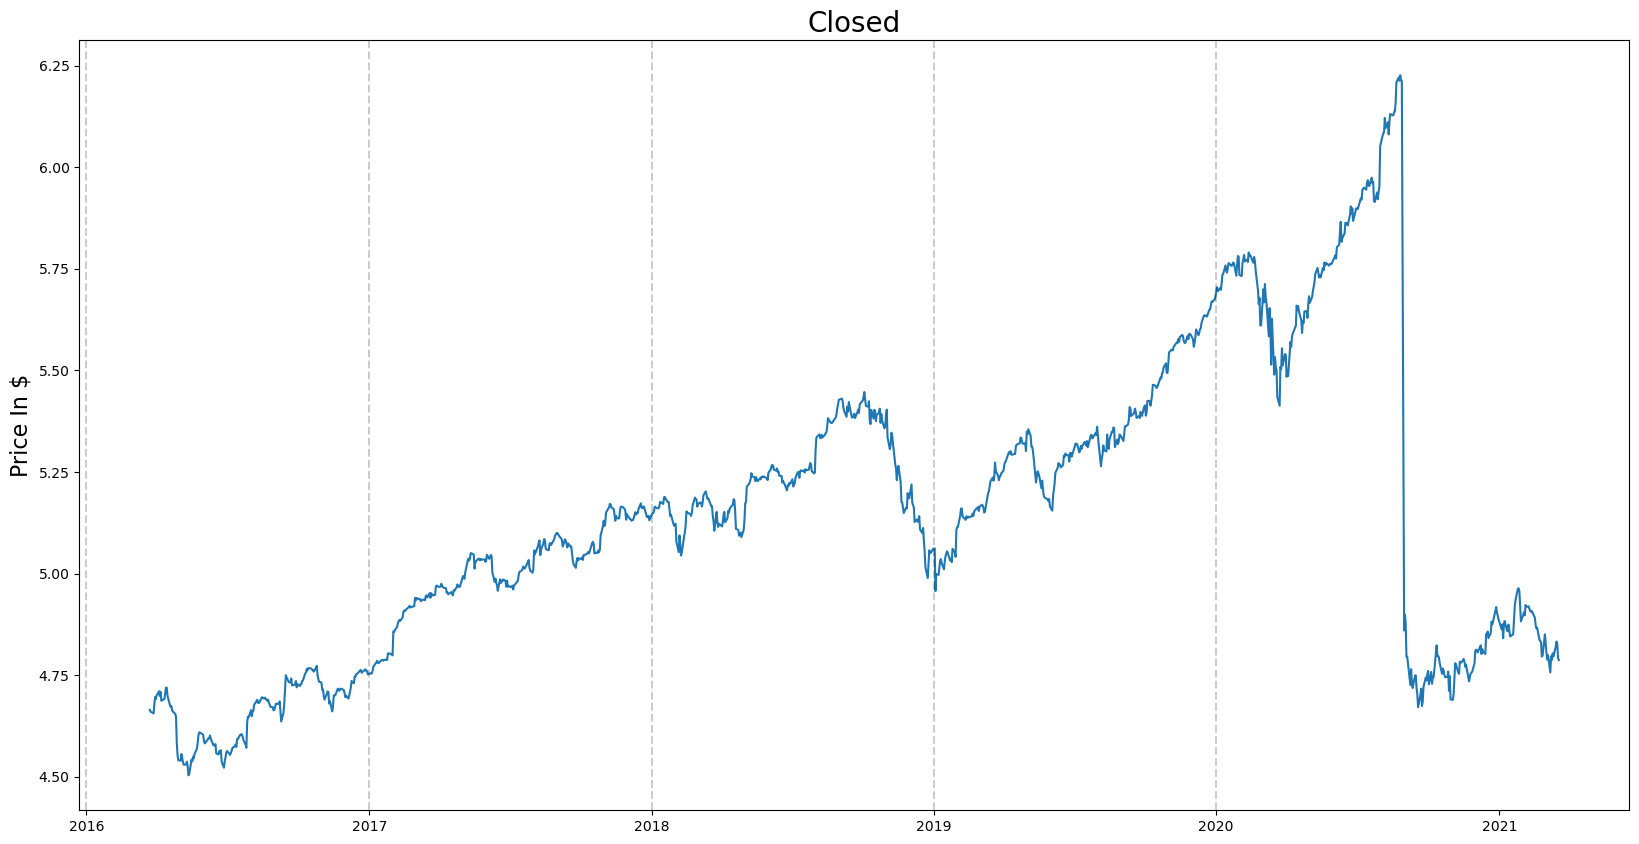

In [58]:
# Plotting the data

plt.figure(figsize=(20,10))
plt.plot(df2.close)
plt.title('Closed', fontsize=20)
plt.ylabel('Price In $', fontsize=16)
for year in range(2016,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [59]:
# Checking Dickey-Fuller test to find if data is stationary 

hypo1 = adfuller(df2.close)
print(hypo1)

(-2.1900940451827187, 0.20986037187155804, 6, 1250, {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776}, -4258.202145300758)


In [60]:
first_diffs = df2.close - df2.close.shift(1)

In [61]:
# Applying transformation to make data statinoary

df2['FirstDifference'] = first_diffs

In [62]:
df2.dropna(inplace=True)

In [63]:
hypo2 = adfuller(df2.FirstDifference)
print(hypo2)

(-14.410721338789198, 8.213462036815169e-27, 5, 1250, {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776}, -4252.97771704041)


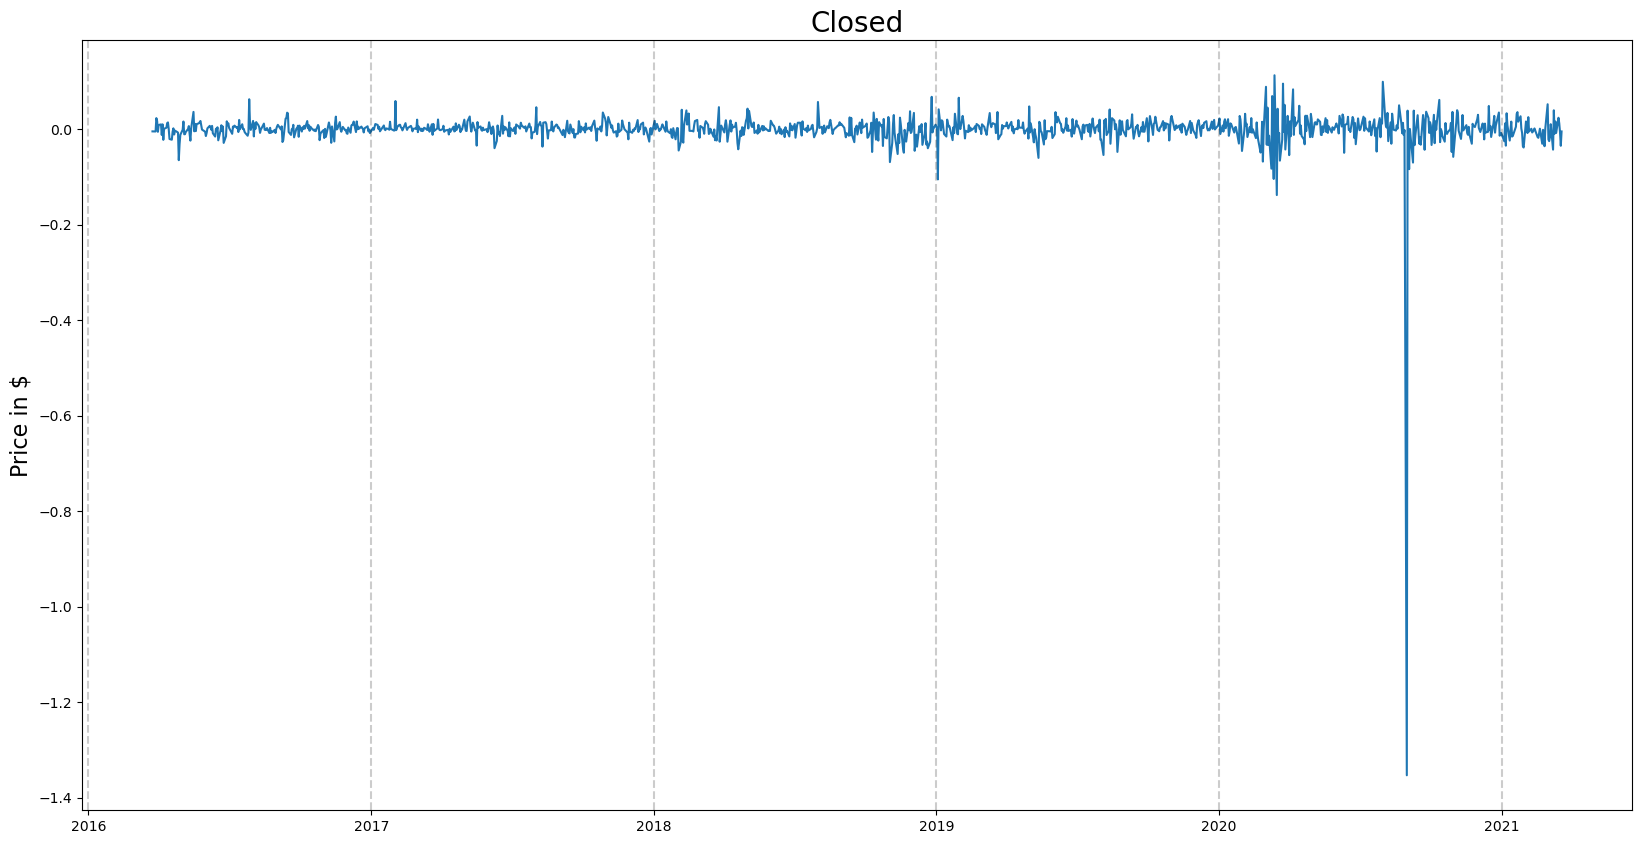

In [64]:
# Plotting the data which is now statinoary

plt.figure(figsize=(20,10))
plt.plot(df2.FirstDifference)
plt.title('Closed', fontsize=20)
plt.ylabel('Price in $', fontsize=16)
for year in range(2016,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

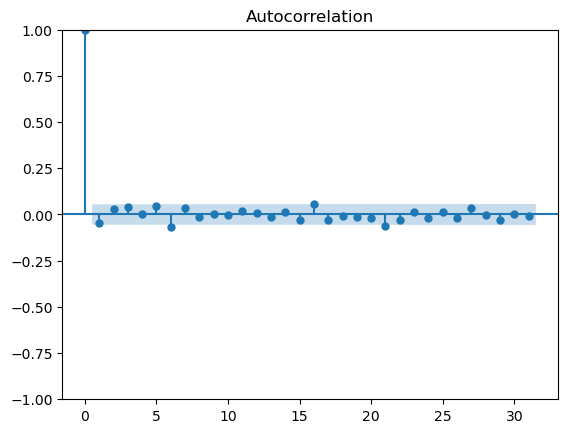

In [65]:
# Plotting ACF plot to choose value for MA 

plot_acf(df2.FirstDifference)
plt.show()

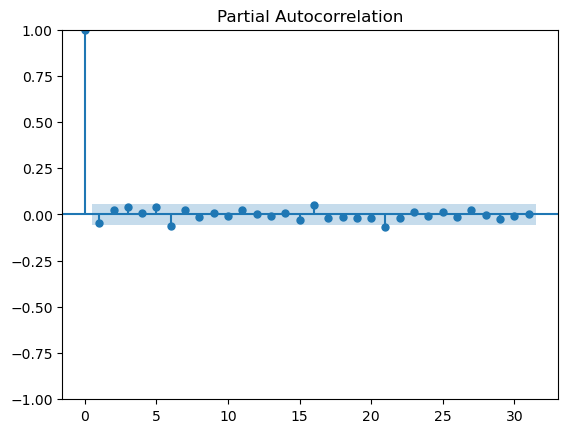

In [66]:
# Plotting PACF plot to choose value for AR

plot_pacf(df2.FirstDifference)
plt.show()

In [67]:
# Creating the ARIMA model and fitting the values

model = ARIMA(df2.FirstDifference.dropna(), order=(1,1,0))
result = model.fit()

c:\Users\rishi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rishi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rishi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [68]:
# Summary for ARIMA model

fvalues = result.fittedvalues
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        FirstDifference   No. Observations:                 1256
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1925.078
Date:                Sun, 22 Sep 2024   AIC                          -3846.156
Time:                        15:27:23   BIC                          -3835.886
Sample:                             0   HQIC                         -3842.296
                               - 1256                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5346      0.002   -258.135      0.000      -0.539      -0.531
sigma2         0.0027   7.71e-06    352.994      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                  46.50   Jarque-Bera (JB):           8181317.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              35.28   Skew:                           -10.14
Prob(H) (two-sided):                  0.00   Kurtosis:                       398.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

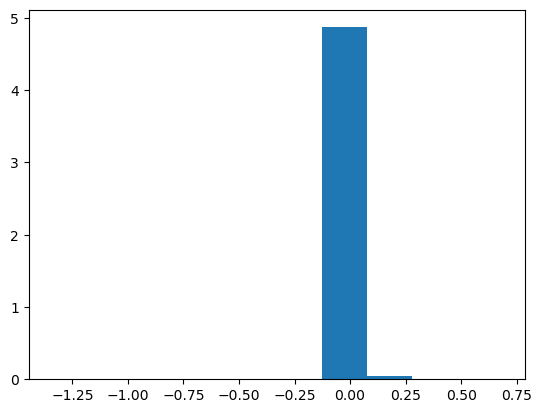

In [69]:
# Plotting residual plot

residual = result.resid
plt.hist(residual, density=True)
plt.show()

[]

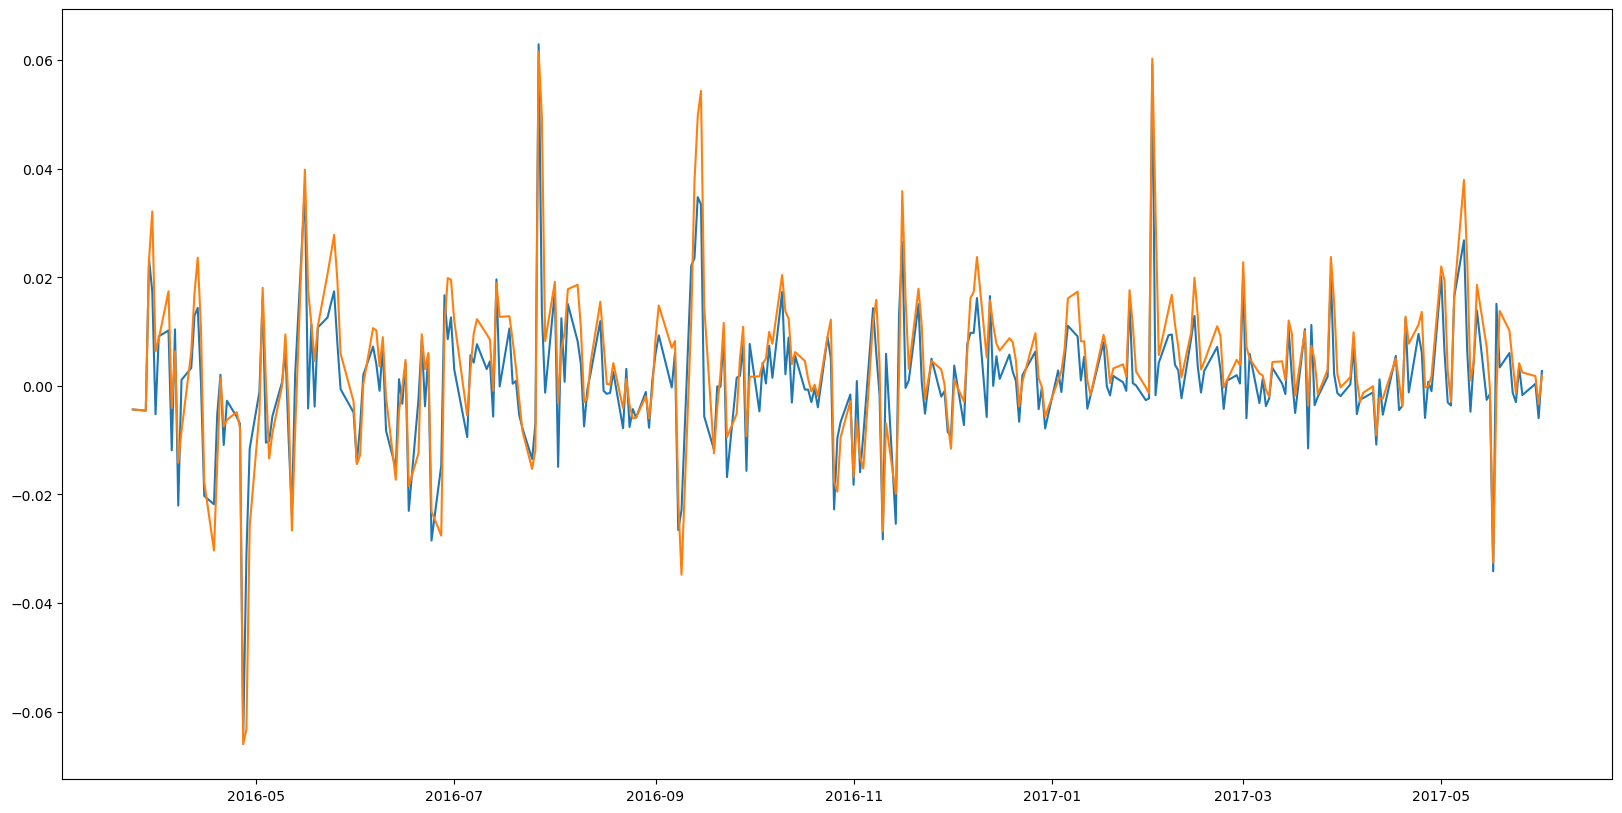

In [70]:
# Plotting the transformed fitted value 

residual = residual.cumsum()
plt.figure(figsize=(20,10))
plt.plot(df2.FirstDifference[:300])
plt.plot(residual[:300])
plt.plot()

In [71]:
# Inversing the transformation to get original data back

a = df2.close - df2.FirstDifference
diff_results = residual + residual.shift(-1)
diff_results = diff_results + a

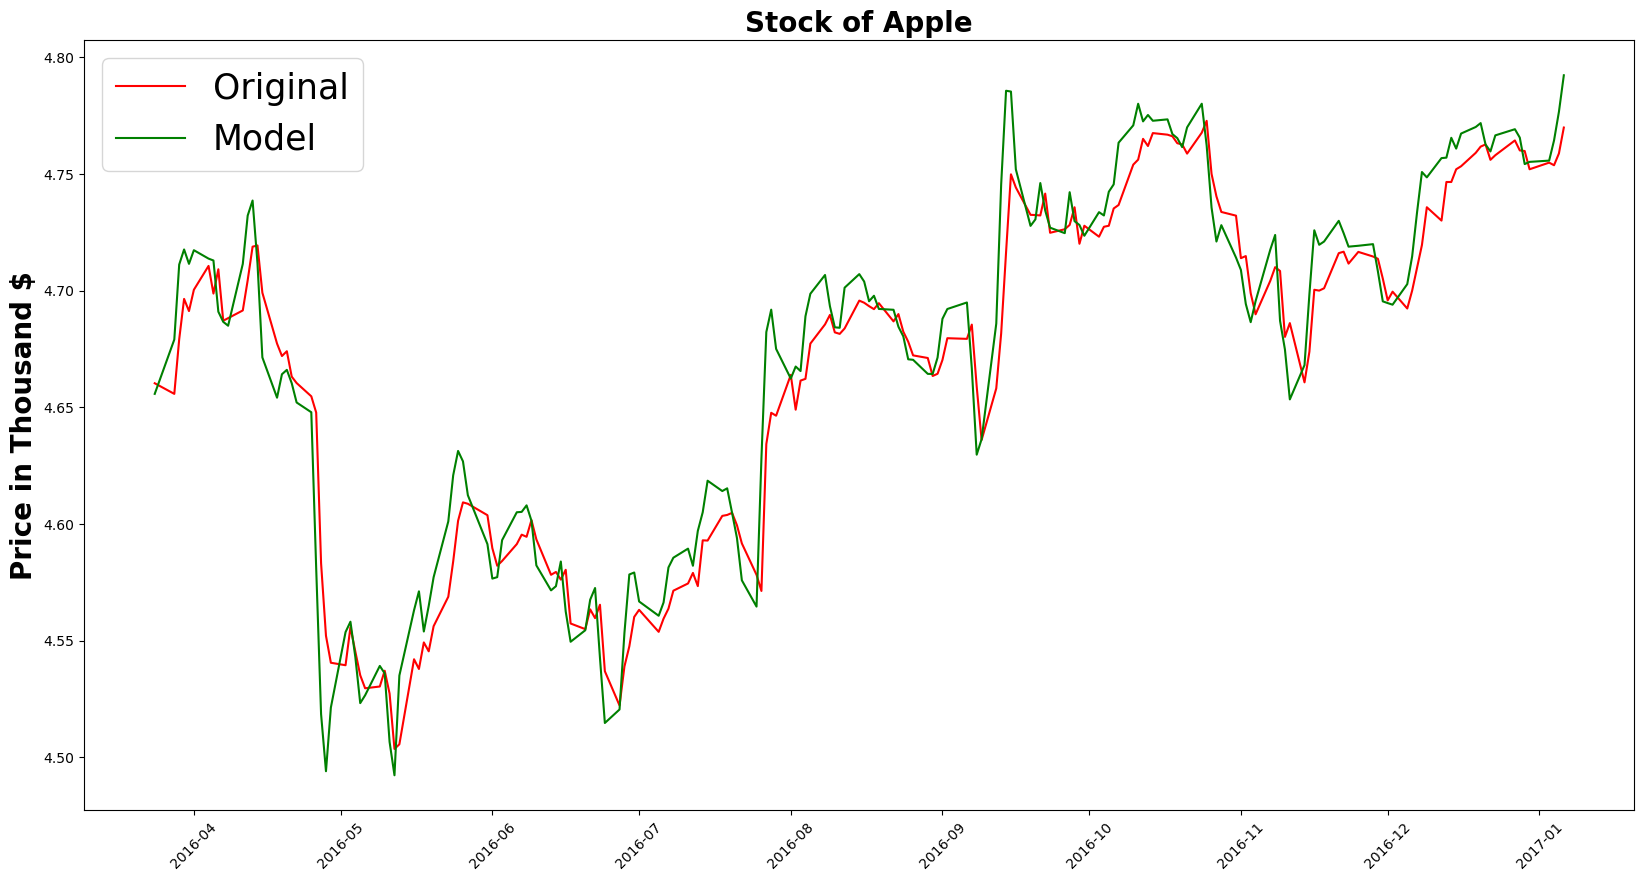

In [72]:
# Plotting the original fitted value

plt.figure(figsize=(20,10))
plt.plot(df2.iloc[:200].close, label='Original', color='red')
plt.plot(diff_results[:200], label='Model', color='green')
plt.title('Stock of Apple', fontweight='bold', fontsize=20)
plt.ylabel('Price in Thousand $', fontweight='bold', fontsize=20)
plt.xticks(rotation=45)
plt.legend(prop={'size':25})
plt.show()

In [73]:
df1 = diff_results

In [74]:
df1.dropna(inplace=True)

In [75]:
# Normalizing the data 

scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [76]:
df1 = df1.reshape(1255)

In [77]:
# Defining the train and test data size

training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[:training_size],df1[training_size:]

In [78]:
len(train_data), len(test_data)

(815, 440)

In [79]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step)]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [80]:
X_train.shape, y_train.shape

((754, 60), (754,))

In [81]:
X_test.shape, y_test.shape

((379, 60), (379,))

In [82]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [83]:
len(X_train), len(y_train), len(X_test), len(y_test)

(754, 754, 379, 379)

In [84]:
# Creating LSTM model

model=Sequential()
model.add(LSTM(30, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])

c:\Users\rishi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [85]:
# Summary for LSTM model

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 30)             │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,871 (15.12 KB)

 Trainable params: 3,871 (15.12 KB)

 Non-trainable params: 0 (0.00 B)

In [1]:
# Fiting data into LSTM model

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64,verbose=1)

NameError: name 'model' is not defined

In [87]:
# Predicting the values from fitted data

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [88]:
# Calculating root mean square error

rmse = math.sqrt(mean_squared_error(y_test,test_predict))
print(rmse)

0.12470751563410044


In [99]:
final_test = pd.DataFrame(df2[877:])

In [100]:
final_test

,close,FirstDifference
date,,
2019-09-18,5.406140,0.009336
2019-09-19,5.397982,-0.008158
2019-09-20,5.383256,-0.014726
2019-09-23,5.387792,0.004537
2019-09-24,5.383026,-0.004766
...,...,...
2021-03-15,4.820201,0.024162
2021-03-16,4.832863,0.012662
2021-03-17,4.826392,-0.006471


In [101]:
test_predict.size

379

In [102]:
# Un-normalizing the data

final_test['test'] = scaler.inverse_transform(test_predict)

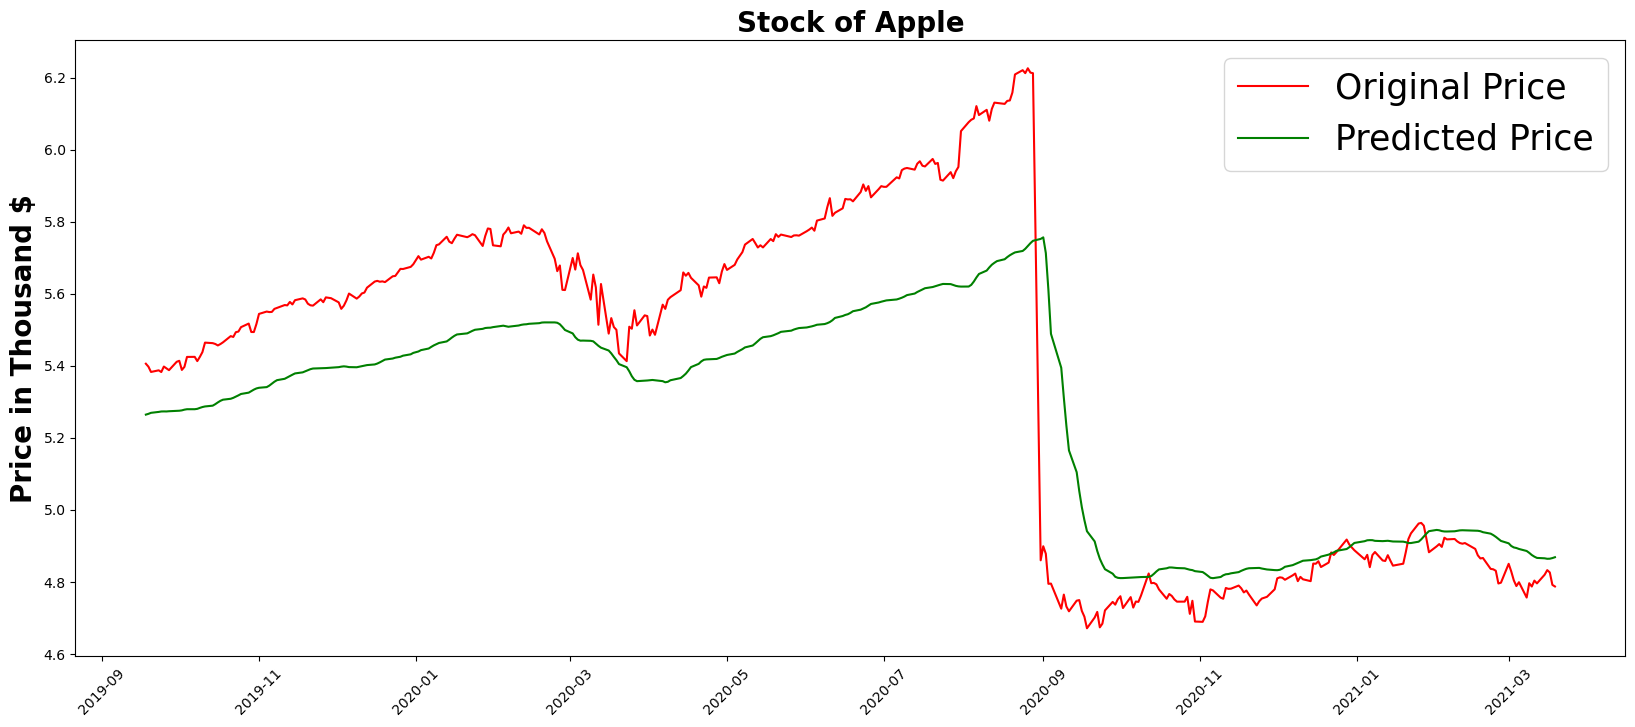

In [103]:
# Plotting the predictied price wrt original price

plt.figure(figsize=(20,8))
plt.plot(final_test.close, label='Original Price', color='red')
plt.plot(final_test.test, label='Predicted Price', color='green')
plt.title('Stock of Apple', fontweight='bold', fontsize=20)
plt.ylabel('Price in Thousand $', fontweight='bold', fontsize=20)
plt.xticks(rotation=45)
plt.legend(prop={'size':25})
plt.show()